In [1]:
import abc
import FokkerPlanck as FP
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Possible OO Approach

Although this wasn't implemented in the original project, we could use the following object oriented approach if this was to become simulation software:

FP_Simulation becomes an object that has $L_1$,$L_2$,$L_3$ objects where $L_1$,$L_2$,$L_3$ are abstract classes/interfaces that need to be implemented. We use these abstract classes/interfaces since each $L_1$,$L_2$,$L_3$ object will fundamentally act the same however have a different implementation (We could use Cranck Nicolson or even a different Explicit Solver).

If we then have the constructor of FP_Simulation require the $L_1$,$L_2$,$L_3$ objects, then we can instantiate all types of different solvers using different $L_1$,$L_2$,$L_3$ stages.  Here we are using composition to improve the usability of the class. A rough outline of this flow is coded up below with a simple UML diagram.

# Possible OO Implementation

In [2]:
# Setting up the exact solution
dim = 81

nx = np.linspace(-4,4,dim)
ny = np.linspace(-4,4,dim)

# nx = np.linspace(-4-np.diff(nx)[0],4+np.diff(nx)[0],dim+2)
# ny = np.linspace(-4-np.diff(ny)[0],4+np.diff(ny)[0],dim+2)

X, Y = np.meshgrid(nx,ny)

#Functions
K=1
gamma = 2.1
sigma = 0.8

a_1 = lambda x,y: K*x
a_2 = lambda x,y: gamma*y
a_3 = lambda x,y: 0
a_4 = lambda x,y: sigma

g = lambda x,y: a_1(x,y)+a_2(x,y)

mu_1 = -gamma/2+np.sqrt(gamma*gamma/4-K)
mu_2 = -gamma/2-np.sqrt(gamma*gamma/4-K)

xi = lambda x,v,t: (x*mu_1-v)*np.exp(-mu_2*t)
nu = lambda x,v,t: (x*mu_2-v)*np.exp(-mu_1*t)

a = lambda t: (sigma/mu_1)*(1-np.exp(-2*mu_1*t))
b = lambda t: (sigma/mu_2)*(1-np.exp(-2*mu_2*t))
h = lambda t: (-2*sigma/(mu_1+mu_2))*(1-np.exp(-(mu_1+mu_2)*t))
delta = lambda t: a(t)*b(t)-h(t)*h(t)

y_0=0
x_0=0

top = lambda x,y,t: (a(t)*(xi(x,y,t)-xi(x_0,y_0,0))**2+2*h(t)*(xi(x,y,t)-xi(x_0,y_0,0))*(nu(x,y,t)-nu(x_0,y_0,0))+b(t)*(nu(x,y,t)-nu(x_0,y_0,0))**2)/(2*delta(t))
rho = lambda x,y,t: np.exp(gamma*t)*np.exp(-top(x,y,t))/(2*np.pi*np.sqrt(delta(t)))

In [3]:
class FP_Simulation():
    
    def __init__(self,L1,L2,L3):
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
        
    def simulate(self, delta_x, delta_t, time_steps, initial_condition, X=None, Y=None, g=None,rho=None, kappa=.8,t_0=0):
        """
        Code meant to combine L1, L2, and L3 steps in order to simulate the Fokker Planck Equations

        :Input:
         - *delta_x* (float) Distance between points in discretization
         - *delta_t* (float) Length of a Time Step
         - *time_steps* (int) Number of time steps
         - *initial_condition* (numpy.ndarray) initial condition
         - *L1* (function) function that represents the L1 operator
         - *L2* (function) function that represents the L2 operator
         - *L2* (function) function that represents the L3 operator
         - *X* (numpy.ndarray) Represents the underlying x1 variable which is involved in the process
         - *Y* (numpy.ndarray) Represents the underlying x2 variable which is involved in the process
         - *g* (function) Represents a function on x1 and x2 that is involved with the L2 term
         - *kappa* (float) Term that controls the diffusion in the L3 operator
         - *t_0* starting time

        :Output:
         - *U* (numpy.ndarray) Solution
        """

        print("Beginning Test")
        U=initial_condition.copy()
        errors=[]

        dim1, dim2 = X.shape
        t=t_0

        for i in range(time_steps):
            t+=delta_t
            U = self.L3.evaluate(U,delta_x,delta_t,kappa=kappa)
            U = self.L1.evaluate(U,delta_x,delta_t,Y=Y)
            U = self.L2.evaluate(U,delta_x,delta_t,X=X,Y=Y,g=g)

            if i%100==0:
                print("@ Timestep {}".format(i))

            error=np.sqrt(np.sum((U-rho(X,Y,t))*(U-rho(X,Y,t)))/(dim1*dim2))
            errors.append(error)

        return U,errors
    
    def print_type(self):
        print("Different Stages:")
        print("------------------")
        self.L1.print_type()
        self.L2.print_type()
        self.L3.print_type()
        print("------------------")

In [4]:
class L_1(abc.ABC):
    @abc.abstractmethod
    def evaluate(self, U,delta_x,delta_t,Y=None):
        pass
    
    @abc.abstractmethod
    def print_type(self):
        pass
    
class L_2(abc.ABC):
    @abc.abstractmethod
    def evaluate(self,U,delta_x,delta_t,X=None,Y=None,g=None):
        pass
    
    @abc.abstractmethod
    def print_type(self):
        pass
    
class L_3(abc.ABC):
    @abc.abstractmethod
    def evaluate(self,U, delta_x, delta_t,kappa=.8):
        pass
    
    @abc.abstractmethod
    def print_type(self):
        pass

#Example Implementation
class EL1(L_1):
    def __init__(self):
        pass
    def evaluate(self, U,delta_x,delta_t,Y=None):
        return FP.explicit_L1(U,delta_x,delta_t,Y=Y)
    def print_type(self):
        print("L1: Explicit")
    
class IL2(L_2):
    def __init__(self):
        pass
    def evaluate(self,U,delta_x,delta_t,X=None,Y=None,g=None):
        return FP.implicit_L2(U,delta_x,delta_t,X=X,Y=Y,g=g)
    def print_type(self):
        print("L2: Implicit")

class CNL3(L_3):
    def __init__(self):
        pass
    def evaluate(self, U, delta_x, delta_t,kappa=.8):
        return FP.solve_CN(U, delta_x, delta_t,kappa=kappa)
    def print_type(self):
        print("L3: Crank Nicholson")

# UML Diagram

<img src="Fokker_Planck_UML.png"></img>

# Example Code

In [5]:
L_1=EL1()
L_2=IL2()
L_3=CNL3()

fps = FP_Simulation(L_1,L_2,L_3)

In [6]:
fps.print_type()

Different Stages:
------------------
L1: Explicit
L2: Implicit
L3: Crank Nicholson
------------------


In [7]:
delta_x = np.diff(nx)[0]
results = fps.simulate(delta_x,np.pi/1000,300,rho(X,Y,0.95),X=X,Y=Y,g=g,rho=rho,t_0=0.95)

Beginning Test
@ Timestep 0
@ Timestep 100
@ Timestep 200


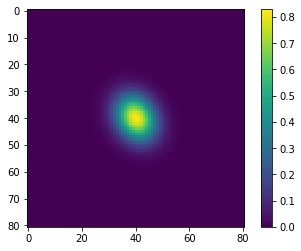

In [8]:
plt.imshow(results[0]);plt.colorbar()

Text(0.5, 0, 'Time Steps Taken')

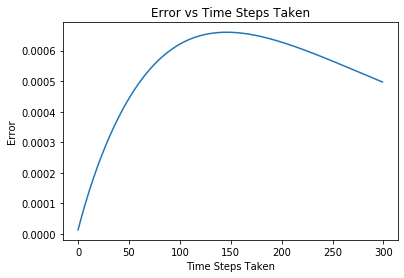

In [9]:
plt.plot(results[1])
plt.title("Error vs Time Steps Taken")
plt.ylabel("Error")
plt.xlabel("Time Steps Taken")